In [2]:
#Manipulating Prosper Loan Data to Recover Prepayment and Default Information
import pandas as pd

file_path = 'prosperLoanData.csv' 
df = pd.read_csv(file_path)
df.head()


df['ListingCreationDate'] = pd.to_datetime(df['ListingCreationDate'],  format='mixed').dt.date
df['ClosedDate'] = pd.to_datetime(df['ClosedDate'],  format='mixed').dt.date


In [3]:
df['LoanStatus'].value_counts()
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26,C,36,Completed,2009-08-14,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27,NaN,36,Current,NaT,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05,HR,36,Completed,2009-12-17,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22,NaN,36,Current,NaT,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14,NaN,36,Current,NaT,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [4]:
#Eliminate loans that were cancelled or late payment less than 60 days, as these are not relevant for our analysis of prepayment and default risk.
df = df[~df['LoanStatus'].isin(['Cancelled', 'Past Due (1-15 days)', 'Past Due (31-60 days)', 'Past Due (16-30 days)'])]
df['LoanStatus'].value_counts()

LoanStatus
Current                   56576
Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (61-90 days)       313
Past Due (91-120 days)      304
FinalPaymentInProgress      205
Past Due (>120 days)         16
Name: count, dtype: int64

In [5]:
#Count up the loans that were prepaid and document how many months were left on the loan at the time of prepayment.
df['CompletedLoans'] = df['LoanStatus'].isin(['Completed', 'FinalPaymentInProgress'])
df['Prepayment'] = df['CompletedLoans'] & ((pd.to_datetime(df['ClosedDate']) - pd.to_datetime(df['LoanOriginationDate'])).dt.days / 30 < df['Term']-1)
#count prepaid loans
prepaid_loans = df['Prepayment'].sum()
print(f"Number of prepaid loans: {prepaid_loans}")

# Calculate the number of months left on the loan at the time of prepayment
df['MonthsLeft'] = df['Term'] - ((pd.to_datetime(df['ClosedDate']) - pd.to_datetime(df['LoanOriginationDate'])).dt.days / 30)
prepaid_loans_months_left = df.loc[df['Prepayment'], 'MonthsLeft']
print(f"Average number of months left on prepaid loans: {prepaid_loans_months_left.mean():.2f}")
#Months after originination until prepayment
df['MonthsToPrepayment'] = (pd.to_datetime(df['ClosedDate']) - pd.to_datetime(df['LoanOriginationDate'])).dt.days / 30
prepaid_loans_months_to_prepayment = df.loc[df['Prepayment'], 'MonthsToPrepayment']
print(f"Average number of months until prepayment: {prepaid_loans_months_to_prepayment.mean():.2f}")

#Calculate the number of months until default for defaulted loans
df['Default'] = df['LoanStatus'].isin(['Defaulted', 'Chargedoff', 'Past Due (60-89 days)', 'Past Due (90+ days)'])
df['MonthsToDefault'] = (pd.to_datetime(df['ClosedDate']) - pd.to_datetime(df['LoanOriginationDate'])).dt.days / 30
defaulted_loans_months_to_default = df.loc[df['Default'], 'MonthsToDefault']
print(f"Average number of months until default: {defaulted_loans_months_to_default.mean():.2f}")

#eliminate loans marked current with term values less than 36



Number of prepaid loans: 27484
Average number of months left on prepaid loans: 22.22
Average number of months until prepayment: 15.28
Average number of months until default: 17.03


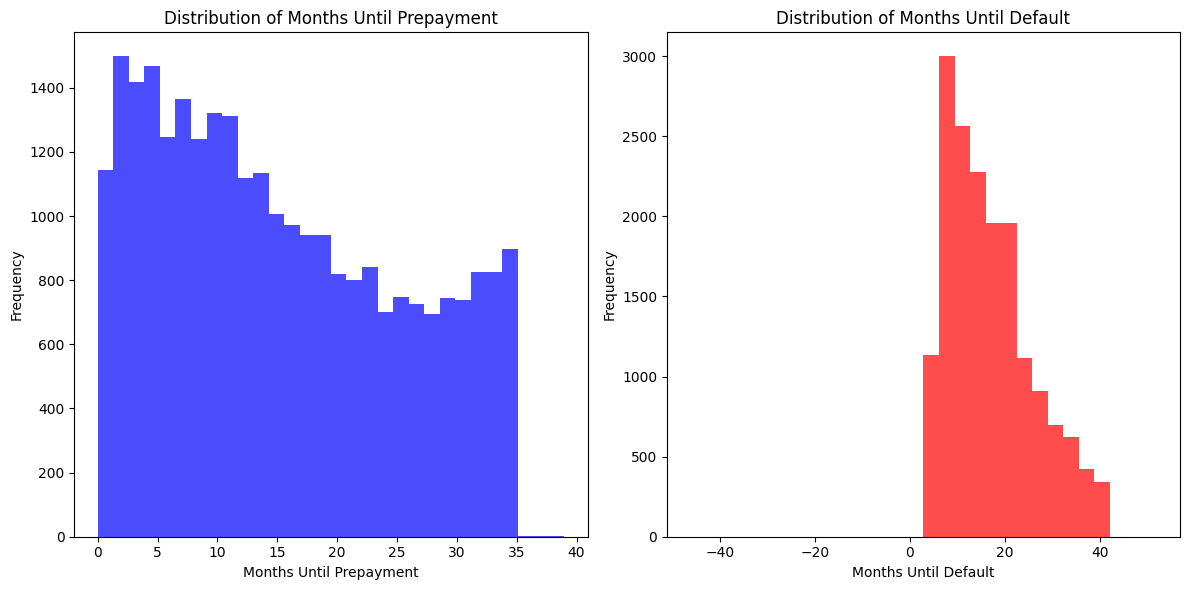

In [6]:
#Plot the distribution of months until prepayment and months until default for the loans that prepaid and defaulted within 24 months after origination.
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(prepaid_loans_months_to_prepayment, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Months Until Prepayment')
plt.xlabel('Months Until Prepayment')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(defaulted_loans_months_to_default, bins=30, color='red', alpha=0.7)
plt.title('Distribution of Months Until Default')
plt.xlabel('Months Until Default')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [7]:
# Ensure proper dates (don't overwrite with term-end!)
df['OrigDate'] = pd.to_datetime(df['LoanOriginationDate'])
df['CloseDate'] = pd.to_datetime(df['ClosedDate'])  # Keep actual event dates

# Time to event (in months) - YOUR EXISTING LOGIC (correct!)
df['MonthsToEvent'] = (df['CloseDate'] - df['OrigDate']).dt.days / 30

# Status AT 12 months: event happened ON OR BEFORE month 12?
df['t_12m'] = df['OrigDate'] + pd.DateOffset(months=12)

prepaid_by_12m  = (df['MonthsToEvent'] <= 12) & df['Prepayment']
defaulted_by_12m = (df['MonthsToEvent'] <= 12) & df['Default']

df['StatusAt12Months'] = 'Active'
df.loc[prepaid_by_12m, 'StatusAt12Months'] = 'Prepaid'
df.loc[defaulted_by_12m, 'StatusAt12Months'] = 'Defaulted'

print(df['StatusAt12Months'].value_counts())
print("Prepaid by 12m:", prepaid_by_12m.sum())
print("Defaulted by 12m:", defaulted_by_12m.sum())


StatusAt12Months
Active       94308
Prepaid      12303
Defaulted     5887
Name: count, dtype: int64
Prepaid by 12m: 12303
Defaulted by 12m: 5887


In [8]:
active_12m = df[df['StatusAt12Months'] == 'Active'].copy()
active_12m['t_24m'] = active_12m['OrigDate'] + pd.DateOffset(months=24)

# Events between 12-24 months
prepaid_12_24 = (active_12m['MonthsToEvent'] > 12) & (active_12m['MonthsToEvent'] <= 24) & active_12m['Prepayment']
defaulted_12_24 = (active_12m['MonthsToEvent'] > 12) & (active_12m['MonthsToEvent'] <= 24) & active_12m['Default']

active_12m['StatusAt24Months'] = 'Active'
active_12m.loc[prepaid_12_24, 'StatusAt24Months'] = 'Prepaid'
active_12m.loc[defaulted_12_24, 'StatusAt24Months'] = 'Defaulted'

print("Status at 24m (for active at 12m):")
print(active_12m['StatusAt24Months'].value_counts())


Status at 24m (for active at 12m):
StatusAt24Months
Active       78289
Prepaid       8614
Defaulted     7405
Name: count, dtype: int64


In [9]:
# Active at 24 months cohort
active_24m = active_12m[active_12m['StatusAt24Months'] == 'Active'].copy()
active_24m['t_36m'] = active_24m['OrigDate'] + pd.DateOffset(months=36)

# Events 24-36 months
prepaid_24_36 = (active_24m['MonthsToEvent'] > 24) & (active_24m['MonthsToEvent'] <= 36) & active_24m['Prepayment']
defaulted_24_36 = (active_24m['MonthsToEvent'] > 24) & (active_24m['MonthsToEvent'] <= 36) & active_24m['Default']

active_24m['StatusAt36Months'] = 'Active'
active_24m.loc[prepaid_24_36, 'StatusAt36Months'] = 'Prepaid'
active_24m.loc[defaulted_24_36, 'StatusAt36Months'] = 'Defaulted'

print("Status at 36m (for active at 24m):")
print(active_24m['StatusAt36Months'].value_counts())

active_36m = active_24m[active_24m['StatusAt36Months'] == 'Active'].copy()

Status at 36m (for active at 24m):
StatusAt36Months
Active       68733
Prepaid       6565
Defaulted     2991
Name: count, dtype: int64


In [10]:
cohort_summary = pd.DataFrame({
    'At12m': [94246, 12303, 5887],
    'At24m': [78227, 8614, 7405],  # Update with 36m when done
    'At36m': [68671, 6565,2991]
}, index=['Active', 'Prepaid', 'Defaulted'])
print("Cohort survival:")
print(cohort_summary)
print("total prepayments within 36m:", cohort_summary.loc['Prepaid'].sum())


Cohort survival:
           At12m  At24m  At36m
Active     94246  78227  68671
Prepaid    12303   8614   6565
Defaulted   5887   7405   2991
total prepayments within 36m: 27482


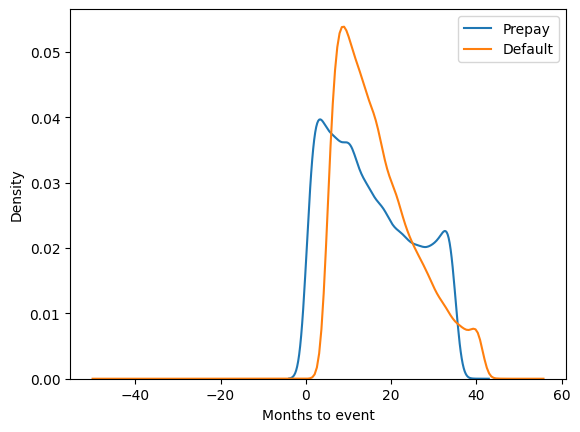

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(df.loc[df['Prepayment'], 'MonthsToPrepayment'], label='Prepay')
sns.kdeplot(df.loc[df['Default'], 'MonthsToDefault'], label='Default')
plt.xlabel('Months to event')
plt.legend()
plt.show()


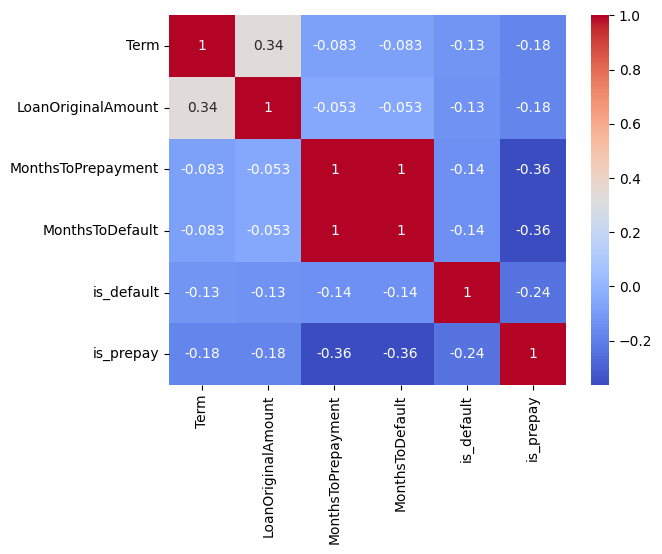

In [12]:
df['is_default'] = df['Default'].astype(int)
df['is_prepay']  = df['Prepayment'].astype(int)

num_cols = ['Term','LoanOriginalAmount','MonthsToPrepayment','MonthsToDefault','is_default','is_prepay']  # add more
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


In [13]:
file_path = 'FEDFUNDS (1).csv'
fed_df = pd.read_csv(file_path)
fed_df['observation_date'] = pd.to_datetime(fed_df['observation_date'])
fed_df.head()

,observation_date,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83


In [14]:
#For each loan, document the FED rate at origination 
df['FED_rate_at_origination'] = df['OrigDate'].apply(lambda x: fed_df.loc[fed_df['observation_date'] <= x, 'FEDFUNDS'].iloc[-1])
df['FED_rate_at_origination'].head(100)

0      4.94
1      0.08
2      5.25
3      0.16
4      0.08
       ... 
97     0.16
98     0.07
99     0.08
100    0.14
101    3.94
Name: FED_rate_at_origination, Length: 100, dtype: float64

In [15]:
#Create columns in loan dataframe to mark if the loan was included in the active_12m dataframe
df['in_active_12m'] = df['ListingKey'].isin(active_12m['ListingKey'])
df['in_active_24m'] = df['ListingKey'].isin(active_24m['ListingKey'])
df['in_active_36m'] = df['ListingKey'].isin(active_36m['ListingKey'])
df.head(20)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,CloseDate,MonthsToEvent,t_12m,StatusAt12Months,is_default,is_prepay,FED_rate_at_origination,in_active_12m,in_active_24m,in_active_36m
0,1021339766868145413AB3B,193129,2007-08-26,C,36,Completed,2009-08-14,0.16516,0.1580,0.1380,...,2009-08-14,23.400000,2008-09-12,Active,0,1,4.94,True,False,False
1,10273602499503308B223C1,1209647,2014-02-27,NaN,36,Current,NaT,0.12016,0.0920,0.0820,...,NaT,NaN,2015-03-03,Active,0,0,0.08,True,True,True
2,0EE9337825851032864889A,81716,2007-01-05,HR,36,Completed,2009-12-17,0.28269,0.2750,0.2400,...,2009-12-17,35.500000,2008-01-17,Active,0,0,5.25,True,True,True
3,0EF5356002482715299901A,658116,2012-10-22,NaN,36,Current,NaT,0.12528,0.0974,0.0874,...,NaT,NaN,2013-11-01,Active,0,0,0.16,True,True,True
4,0F023589499656230C5E3E2,909464,2013-09-14,NaN,36,Current,NaT,0.24614,0.2085,0.1985,...,NaT,NaN,2014-09-20,Active,0,0,0.08,True,True,True
5,0F05359734824199381F61D,1074836,2013-12-14,NaN,60,Current,NaT,0.15425,0.1314,0.1214,...,NaT,NaN,2014-12-24,Active,0,0,0.09,True,True,True
6,0F0A3576754255009D63151,750899,2013-04-12,NaN,36,Current,NaT,0.31032,0.2712,0.2612,...,NaT,NaN,2014-04-18,Active,0,0,0.15,True,True,True
7,0F1035772717087366F9EA7,768193,2013-05-05,NaN,36,Current,NaT,0.23939,0.2019,0.1919,...,NaT,NaN,2014-05-13,Active,0,0,0.11,True,True,True
8,0F043596202561788EA13D5,1023355,2013-12-02,NaN,36,Current,NaT,0.07620,0.0629,0.0529,...,NaT,NaN,2014-12-12,Active,0,0,0.09,True,True,True
9,0F043596202561788EA13D5,1023355,2013-12-02,NaN,36,Current,NaT,0.07620,0.0629,0.0529,...,NaT,NaN,2014-12-12,Active,0,0,0.09,True,True,True


In [16]:
#For each loan, calculate the average FED rate over the 12 months after origination 
df['FED_rate_12m_avg'] = df['OrigDate'].apply(lambda x: fed_df.loc[(fed_df['observation_date'] > x) & (fed_df['observation_date'] <= x + pd.DateOffset(months=12)), 'FEDFUNDS'].mean())

#We also calculate the average FED rate from months 12 to 24, and from months 24 to 36, to see if changes in the FED rate after origination have any relationship with prepayment or default risk.
df['FED_rate_12_24m_avg'] = df['OrigDate'].apply(lambda x: fed_df.loc[(fed_df['observation_date'] > x + pd.DateOffset(months=12)) & (fed_df['observation_date'] <= x + pd.DateOffset(months=24)), 'FEDFUNDS'].mean())
df['FED_rate_24_36m_avg'] = df['OrigDate'].apply(lambda x: fed_df.loc[(fed_df['observation_date']> x +pd.DateOffset(months=24)) & (fed_df['observation_date'] <= x + pd.DateOffset(months=36)), 'FEDFUNDS'].mean())
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,StatusAt12Months,is_default,is_prepay,FED_rate_at_origination,in_active_12m,in_active_24m,in_active_36m,FED_rate_12m_avg,FED_rate_12_24m_avg,FED_rate_24_36m_avg
0,1021339766868145413AB3B,193129,2007-08-26,C,36,Completed,2009-08-14,0.16516,0.1580,0.1380,...,Active,0,1,4.94,True,False,False,2.925000,0.256667,0.158333
1,10273602499503308B223C1,1209647,2014-02-27,NaN,36,Current,NaT,0.12016,0.0920,0.0820,...,Active,0,0,0.08,True,True,True,0.098333,0.195000,0.480000
2,0EE9337825851032864889A,81716,2007-01-05,HR,36,Completed,2009-12-17,0.28269,0.2750,0.2400,...,Active,0,0,5.25,True,True,True,4.910000,1.611667,0.156667
3,0EF5356002482715299901A,658116,2012-10-22,NaN,36,Current,NaT,0.12528,0.0974,0.0874,...,Active,0,0,0.16,True,True,True,0.113333,0.086667,0.122500
4,0F023589499656230C5E3E2,909464,2013-09-14,NaN,36,Current,NaT,0.24614,0.2085,0.1985,...,Active,0,0,0.08,True,True,True,0.085833,0.117500,0.322500


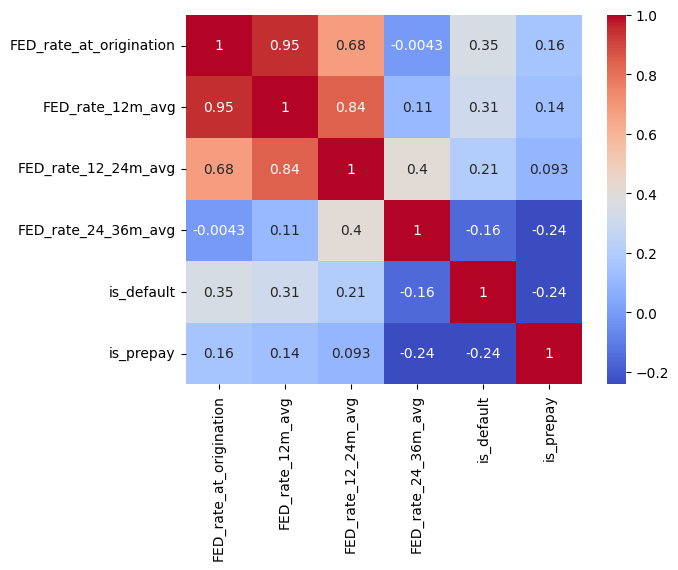

In [17]:
#Now we can analyze whether the FED rate at origination or changes in the FED rate after origination have any relationship with prepayment or default risk. For example, we can compare the average FED rates for loans that prepaid vs. those that defaulted, or we can look at how changes in the FED rate over time correlate with prepayment/default outcomes.
#We begin with a heatmap to see how the FED rates at origination and the average FED rates over time correlate with prepayment and default outcomes.
fed_cols = ['FED_rate_at_origination', 'FED_rate_12m_avg', 'FED_rate_12_24m_avg', 'FED_rate_24_36m_avg']
corr = df[fed_cols + ['is_default', 'is_prepay']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

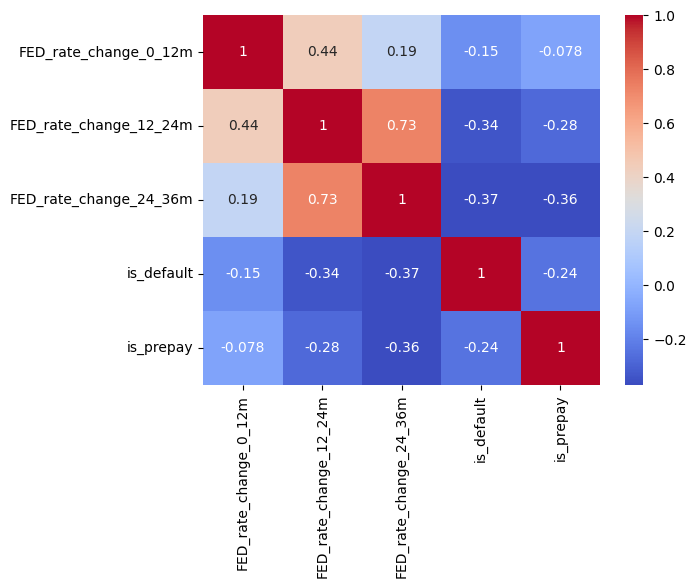

In [18]:
#Adjust to percent change in FED rate from origination to 12m, 12m to 24m, and 24m to 36m, to see if changes in the FED rate have any relationship with prepayment or default risk.
df['FED_rate_change_0_12m'] = (df['FED_rate_12m_avg'] - df['FED_rate_at_origination']) / df['FED_rate_at_origination']
df['FED_rate_change_12_24m'] = (df['FED_rate_12_24m_avg'] - df['FED_rate_12m_avg']) / df['FED_rate_12m_avg']
df['FED_rate_change_24_36m'] = (df['FED_rate_24_36m_avg'] - df['FED_rate_12_24m_avg']) / df['FED_rate_12_24m_avg']

#redo heat map with percent changes in FED rate
fed_change_cols = ['FED_rate_change_0_12m', 'FED_rate_change_12_24m', 'FED_rate_change_24_36m']
corr = df[fed_change_cols + ['is_default', 'is_prepay']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

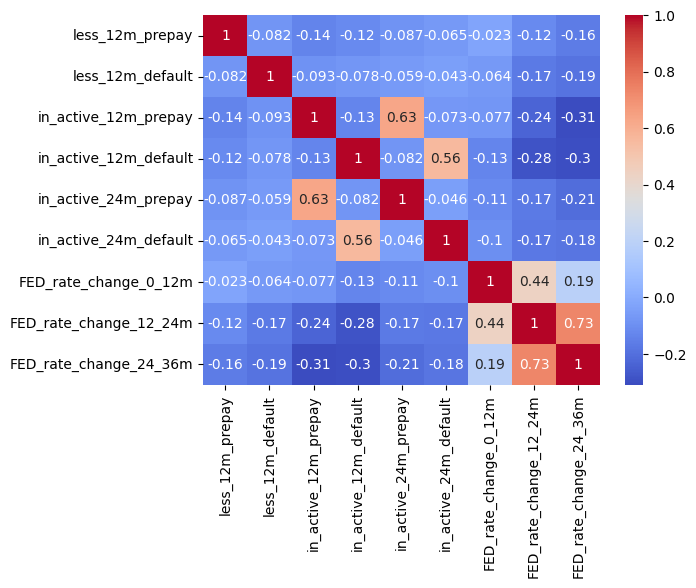

In [19]:
#Add in 1-hot coded columns for whether the loan was not active at 12m and prepaid or defaulted 
df['less_12m_prepay'] = (df['in_active_12m'] == False) & (df['is_prepay'] == 1)
df['less_12m_default'] = (df['in_active_12m'] == False) & (df['is_default'] == 1)
df['less_12m_prepay'] = df['less_12m_prepay'].astype(int)
df['less_12m_default'] = df['less_12m_default'].astype(int)

#Add in 1-hot coded columns for loans in active_12m that prepaid or defaulted by 24m
df['in_active_12m_prepay'] = (df['in_active_12m'] == True) & (df['is_prepay'] == 1)
df['in_active_12m_default'] = (df['in_active_12m'] == True) & (df['is_default'] == 1)
df['in_active_12m_prepay'] = df['in_active_12m_prepay'].astype(int)
df['in_active_12m_default'] = df['in_active_12m_default'].astype(int)

#Repeat for in active_24m and prepaid or defaulted by 36m
df['in_active_24m_prepay'] = (df['in_active_24m'] == True) & (df['is_prepay'] == 1)
df['in_active_24m_default'] = (df['in_active_24m'] == True) & (df['is_default'] == 1)
df['in_active_24m_prepay'] = df['in_active_24m_prepay'].astype(int)
df['in_active_24m_default'] = df['in_active_24m_default'].astype(int)

#Repeat heatmap with these 1-hot coded columns to see how they correlate with the FED rate variables and with prepayment/default outcomes.
#Heatmap with 1-hot coded columns
hot_cols = ['less_12m_prepay', 'less_12m_default', 'in_active_12m_prepay', 'in_active_12m_default', 'in_active_24m_prepay', 'in_active_24m_default']
corr = df[hot_cols + fed_change_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [20]:
#Repeat with MPrime loan data
file_path = 'MPRIME.csv'
mp_df = pd.read_csv(file_path)
mp_df['observation_date'] = pd.to_datetime(mp_df['observation_date'])
mp_df.head()

,observation_date,MPRIME
0,2005-01-01,5.25
1,2005-02-01,5.49
2,2005-03-01,5.58
3,2005-04-01,5.75
4,2005-05-01,5.98


In [21]:
#Add in MPrime percent change between loan origination and the average prime rate over the 12 months following origination
df['Prime_rate_at_origination'] = df['OrigDate'].apply(lambda x: mp_df.loc[mp_df['observation_date'] <= x, 'MPRIME'].iloc[-1])
df['Avg_prime_rate_next_12_months'] = df['OrigDate'].apply(lambda x: mp_df.loc[(mp_df['observation_date'] > x) & (mp_df['observation_date'] <= x + pd.DateOffset(months=12)), 'MPRIME'].mean())
df['MPRIME_change'] = (df['Avg_prime_rate_next_12_months'] - df['Prime_rate_at_origination']) / df['Prime_rate_at_origination'] * 100
#Repeat for the percent change between 12 month average and the average prime rate over months 12-24
df['Avg_prime_rate_months_12_24'] = df['OrigDate'].apply(lambda x: mp_df.loc[(mp_df['observation_date'] > x + pd.DateOffset(months=12)) & (mp_df['observation_date'] <= x + pd.DateOffset(months=24)), 'MPRIME'].mean())
df['MPRIME_change_12_24'] = (df['Avg_prime_rate_months_12_24'] - df['Avg_prime_rate_next_12_months']) / df['Avg_prime_rate_next_12_months'] * 100
#Again for the percent change between 24 month average and the average prime rate over months 24-36
df['Avg_prime_rate_months_24_36'] = df['OrigDate'].apply(lambda x: mp_df.loc[(mp_df['observation_date'] > x + pd.DateOffset(months=24)) & (mp_df['observation_date'] <= x + pd.DateOffset(months=36)), 'MPRIME'].mean())
df['MPRIME_change_24_36'] = (df['Avg_prime_rate_months_24_36'] - df['Avg_prime_rate_months_12_24']) / df['Avg_prime_rate_months_12_24'] * 100

In [ ]:
#Repeat with a heatmap to visualize the correlation between MPRIME changes and default/prepayment rates

import matplotlib.pyplot as plt

# Calculate correlation matrix
corr_matrix = df[['MPRIME_change', 'MPRIME_change_12_24', 'MPRIME_change_24_36', 'is_default', 'is_prepay']].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between MPRIME Changes and Default/Prepayment Rates')
plt.show()  

KeyError: "['DefaultRate', 'PrepaymentRate'] not in index"